In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import h5py
import tqdm.notebook
import sklearn.metrics
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Any

In [2]:
data = {
    'eplus': h5py.File('data/eplus_angle_position_5deg_xy.h5'),
    'piplus': h5py.File('data/piplus_angle_position_5deg_xy.h5'),
    'gamma': h5py.File('data/gamma_angle_position_5deg_xy.h5'),
}

In [31]:
if torch.cuda.is_available():
    print('Models will be run on a GPU (CUDA/HIP)')
    dev = torch.device('cuda')
else:
    print('Models will be run on a CPU')
    dev = torch.device('cpu')

Models will be run on a GPU (CUDA/HIP)


In [32]:
def sample_sizes(size_a: int, size_b: int, num_samples: int) -> Tuple[int, int]:
    num_a_samples = min(
        np.random.binomial(num_samples, size_a / (size_a + size_b)),
        size_a,
    )
    num_b_samples = min(num_samples - num_a_samples, size_b)
    num_a_samples = min(num_samples - num_b_samples, size_a)
    assert num_a_samples + num_b_samples == min(num_samples, size_a + size_b)
    return num_a_samples, num_b_samples

class SamplerEpoch:
    def __init__(
        self,
        num_a_indices: int,
        num_b_indices: int,
        minibatch_size: int,
        id: Optional[int],
        cursor_a: int = 0,
        cursor_b: int = 0
    ) -> None:
        self.minibatch_size = minibatch_size
        self.id = id
        self.num_a_indices = num_a_indices
        self.num_b_indices = num_b_indices
        self.initial_cursor_a = cursor_a
        self.initial_cursor_b = cursor_b
        self.cursor_a = cursor_a
        self.cursor_b = cursor_b
    
    def __iter__(self) -> 'SamplerEpoch':
        return self

    def __next__(self):
        num_a_items_left = self.num_a_indices - self.cursor_a
        num_b_items_left = self.num_b_indices - self.cursor_b
        assert num_a_items_left >= 0
        assert num_b_items_left >= 0
        
        if num_a_items_left == num_b_items_left == 0:
            raise StopIteration()

        num_a_items, num_b_items = sample_sizes(
            num_a_items_left,
            num_b_items_left,
            self.minibatch_size,
        )
        
        begin_a = self.cursor_a
        end_a = begin_a + num_a_items
        begin_b = self.cursor_b
        end_b = begin_b + num_b_items
        
        self.cursor_a = end_a
        self.cursor_b = end_b
        # Only the last mini-batch may be incomplete.
        assert num_a_items + num_b_items == self.minibatch_size or (
            self.cursor_a == self.num_a_indices
            and self.cursor_b == self.num_b_indices
        )
        return (begin_a, end_a), (begin_b, end_b)
    
    def __len__(self):
        num_indices = self.num_a_indices + self.num_b_indices - self.initial_cursor_a - self.initial_cursor_b
        batch = self.minibatch_size
        return (num_indices + batch - 1) // batch
    
    def __repr__(self) -> str:
        return (
            f'SamplerEpoch(id={self.id}), '
            f'minibatch_size={self.minibatch_size}, '
            f'num_indices=({self.num_a_indices}, {self.num_b_indices}), '
            f'cursor=({self.cursor_a}, {self.cursor_b}))'
        )

class Sampler:
    def __init__(
        self,
        num_samples_a: int,
        num_samples_b: int,
        minibatch_size: int,
        cv_split: float,
    ) -> None:
        while True:
            num_cv_indices_a = round(num_samples_a * cv_split)
            num_cv_indices_b = round(num_samples_b * cv_split)
            self.cv_start_a = num_samples_a - num_cv_indices_a
            self.cv_start_b = num_samples_b - num_cv_indices_b
            if (self.cv_start_a + self.cv_start_b) % minibatch_size == 1:
                cv_split *= 0.9999
            else:
                break
        self.num_samples_a = num_samples_a
        self.num_samples_b = num_samples_b
        self.minibatch_size = minibatch_size
        self.num_epochs = 0
    
    def epoch(self) -> SamplerEpoch:
        self.num_epochs += 1
        return SamplerEpoch(
            self.cv_start_a,
            self.cv_start_a,
            minibatch_size=self.minibatch_size,
            id=self.num_epochs,
        )
    
    def cv(self) -> SamplerEpoch:
        return SamplerEpoch(
            self.num_samples_a,
            self.num_samples_b,
            minibatch_size=self.minibatch_size,
            id=None,
            cursor_a=self.cv_start_a,
            cursor_b=self.cv_start_b,
        )

    def __repr__(self) -> str:
        return (
            f'Sampler(cv_start=({self.cv_start_a}, {self.cv_start_b}), '
            f'num_samples=({self.num_samples_a}, {self.num_samples_b}), '
            f'minibatch_size={self.minibatch_size}, '
            f'self.num_epochs={self.num_epochs})'
        )

In [33]:
from functools import reduce

def get_layers(data_file: h5py.File, begin: int, end: int) -> List[np.ndarray]:
    layers = []
    for i in range(3):
        layer = data_file[f'layer_{i}']
        layer_part = layer[begin:end]
        layers.append(layer_part)
    return layers

def flatten_layers(data_file: h5py.File, begin: int, end: int) -> np.ndarray:
    layers = get_layers(data_file, begin, end)
    
    for i, layer in enumerate(layers):
        feature_size = reduce(lambda a, b: a * b, layer.shape[1:])
        reshaped = layer.reshape((layer.shape[0], feature_size))
        layers[i] = reshaped
        
    return np.hstack(layers)

In [34]:
from abc import abstractmethod, ABC

class BaseModel(torch.nn.Module, ABC):
    @abstractmethod
    def prepare_input(
        self,
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        """Prepare input data from the dataset slices and return tensors `X` and `y` on `dev`."""
        ...
    
    @abstractmethod
    def description(self) -> str:
        """Briefly describe this model."""
        ...

In [35]:
class ModelFcPixel(BaseModel):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            self.make_layer(504, 512),
            self.make_layer(512, 1024),
            self.make_layer(1024, 2048),
            self.make_layer(2048, 1024),
            self.make_layer(1024, 128),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_layer(num_in, num_out):
        return torch.nn.Sequential(
            torch.nn.Linear(num_in, num_out),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.BatchNorm1d(num_out),
        )
        
    def forward(self, x):
        return self.layers(x)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x_a = flatten_layers(data_a, begin_a, end_a)
        x_b = flatten_layers(data_b, begin_b, end_b)
        x = torch.Tensor(np.vstack([x_a, x_b])).to(dev)
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b)).to(dev)
        return x, y
    
    @staticmethod
    def description() -> str:
        return 'FC network on pixel intensities'

In [36]:
class AssertShape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.required_shape = torch.Size(shape)
    
    def forward(self, x):
        actual_shape = x.shape[1:]
        if actual_shape != self.required_shape:
            raise ValueError(f'Invalid shape: expected {self.required_shape}, got {actual_shape}')
        return x

In [37]:
for key, value in data['eplus'].items():
    print(f'{key} => {value.shape}')

energy => (400000, 1)
layer_0 => (400000, 3, 96)
layer_1 => (400000, 12, 12)
layer_2 => (400000, 12, 6)
overflow => (400000, 3)
px => (400000, 1)
py => (400000, 1)
pz => (400000, 1)
t0 => (400000, 1)
x0 => (400000, 1)
y0 => (400000, 1)
z0 => (400000, 1)


In [38]:
from functools import reduce

def move_tensors_to(tensors, device):
    shapes = [tensor.shape for tensor in tensors]
    all_flat = torch.cat([tensor.flatten() for tensor in tensors], 0)
    all_flat = all_flat.to(device)
    sizes = [reduce(lambda a, b: a * b, shape) for shape in shapes]
    
    moved_tensors = []
    cumulative_size = 0
    for shape, size in zip(shapes, sizes):
        new_cumulative_size = cumulative_size + size
        flat_tensor = all_flat[cumulative_size:new_cumulative_size]
        moved_tensors.append(flat_tensor.view(*shape))
        cumulative_size = new_cumulative_size
    return moved_tensors

In [79]:
class ConcatResidual(torch.nn.Module):
    def __init__(self, inner: torch.nn.Module) -> None:
        super().__init__()
        self.inner = inner
    
    def forward(self, x):
        
        x_add = self.inner(x)
        assert len(x_add.shape) == len(x.shape)
        
        channel_axis = 1
        for i in range(len(x.shape)):
            if i != channel_axis and x_add.shape[i] != x.shape[i]:
                raise Exception(f'Concat shape mismatch: {x_add.shape} vs {x.shape}')
                
        return torch.cat([x, x_add], channel_axis)

In [80]:
# Reference: https://github.com/hep-lbdl/CaloGAN/blob/v1.0/models/architectures.py.
# Paper: https://arxiv.org/abs/1712.10321.
class ModelConv3(BaseModel):
    def __init__(self):
        super().__init__()
        self.layers_0 = torch.nn.Sequential(
            AssertShape(1, 3, 96),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 3, 48),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 4, 49),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 5, 25),
            
            torch.nn.Flatten(),
            AssertShape(1000),
        )
        self.layers_1 = torch.nn.Sequential(
            AssertShape(1, 12, 12),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 6),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 7),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 4),
            
            torch.nn.Flatten(),
            AssertShape(448),
        )
        self.layers_2 = torch.nn.Sequential(
            AssertShape(1, 12, 6),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 3),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 4),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 3),
            
            torch.nn.Flatten(),
            AssertShape(336),
        )
        flat_size = 1000 + 448 + 336
        self.layers_post = torch.nn.Sequential(
            AssertShape(flat_size),
            torch.nn.Linear(flat_size, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_conv_layer(num_in, num_out, kernel=3, norm=True, padding='same', stride=1):
        return torch.nn.Sequential(
            torch.nn.Conv2d(num_in, num_out, kernel, padding=padding, stride=stride),
            torch.nn.LeakyReLU(),
            #torch.nn.Dropout(),
            *([torch.nn.BatchNorm2d(num_out)] if norm else []),
        )
        
    def forward(self, x):
        x0, x1, x2 = x
        p0 = self.layers_0(x0)
        p1 = self.layers_1(x1)
        p2 = self.layers_2(x2)
        p = torch.cat((p0, p1, p2), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return '3-stream convolution network'

In [ ]:
# Reference: https://github.com/hep-lbdl/CaloGAN/blob/v1.0/models/architectures.py.
# Paper: https://arxiv.org/abs/1712.10321.
class ModelConv3(BaseModel):
    def __init__(self):
        super().__init__()
        self.layers_0 = torch.nn.Sequential(
            AssertShape(1, 3, 96),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 3, 48),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 4, 49),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 5, 25),
            
            torch.nn.Flatten(),
            AssertShape(1000),
        )
        self.layers_1 = torch.nn.Sequential(
            AssertShape(1, 12, 12),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 6),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 7),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 4),
            
            torch.nn.Flatten(),
            AssertShape(448),
        )
        self.layers_2 = torch.nn.Sequential(
            AssertShape(1, 12, 6),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 3),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 4),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 3),
            
            torch.nn.Flatten(),
            AssertShape(336),
        )
        flat_size = 1000 + 448 + 336
        self.layers_post = torch.nn.Sequential(
            AssertShape(flat_size),
            torch.nn.Linear(flat_size, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_conv_layer(num_in, num_out, kernel=3, norm=True, padding='same', stride=1):
        return torch.nn.Sequential(
            torch.nn.Conv2d(num_in, num_out, kernel, padding=padding, stride=stride),
            torch.nn.LeakyReLU(),
            #torch.nn.Dropout(),
            *([torch.nn.BatchNorm2d(num_out)] if norm else []),
        )
        
    def forward(self, x):
        x0, x1, x2 = x
        p0 = self.layers_0(x0)
        p1 = self.layers_1(x1)
        p2 = self.layers_2(x2)
        p = torch.cat((p0, p1, p2), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return '3-stream convolution network'

In [346]:
# Paper: https://arxiv.org/abs/1608.06993
class ModelDenseNet3(BaseModel):
    def __init__(self):
        super().__init__()
        
        # Growth rate.
        k = self.k = 8
        
        self.layers_0 = torch.nn.Sequential(
            AssertShape(1, 3, 96),
            self.make_densenet_layer(1, k - 1),
            
            self.make_densenet_layer(k, k),
            self.make_transition_layer(2 * k, stride=(1, 2)),
            AssertShape(2 * k, 3, 48),
            
            self.make_densenet_layer(2 * k, k),
            self.make_transition_layer(3 * k, stride=(1, 2)),
            AssertShape(3 * k, 3, 24),
            
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=(1, 2)),
            AssertShape(4 * k, 3, 12),
            
            torch.nn.Flatten(),
            AssertShape(144 * k),
            torch.nn.Linear(144 * k, 100),
            torch.nn.LeakyReLU(),
        )
        
        self.layers_1 = torch.nn.Sequential(
            AssertShape(1, 12, 12),
            self.make_densenet_layer(1, k - 1),
            
            self.make_densenet_layer(k, k),
            self.make_transition_layer(2 * k, stride=2),
            AssertShape(2 * k, 6, 6),
            
            self.make_densenet_layer(2 * k, k),
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=2),
            AssertShape(4 * k, 3, 3),
            
            torch.nn.Flatten(),
            AssertShape(36 * k),
            torch.nn.Linear(36 * k, 80),
            torch.nn.LeakyReLU(),
        )
        
        self.layers_2 = torch.nn.Sequential(
            AssertShape(1, 12, 6),
            self.make_densenet_layer(1, k - 1),
            
            self.make_densenet_layer(k, k),
            self.make_transition_layer(2 * k, stride=(2, 1)),
            AssertShape(2 * k, 6, 6),
            
            self.make_densenet_layer(2 * k, k),
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=2),
            AssertShape(4 * k, 3, 3),
            
            torch.nn.Flatten(),
            AssertShape(36 * k),
            torch.nn.Linear(36 * k, 80),
            torch.nn.LeakyReLU(),
        )
        
        flat_size = 100 + 80 + 80
        self.layers_post = torch.nn.Sequential(
            AssertShape(flat_size),
            torch.nn.Linear(flat_size, 300),
            torch.nn.BatchNorm1d(300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 1),
            torch.nn.Sigmoid(),
        )
    
    def make_densenet_layer(self, num_in, num_add, kernel=3):
        submodule = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_in),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(num_in, num_add, kernel, padding='same'),
        )
        return ConcatResidual(submodule)
    
    def make_transition_layer(self, num_channels, stride):
        return torch.nn.AvgPool2d(stride)
    
        # The following does not perform better.
        
        #return torch.nn.Sequential(
        #    torch.nn.BatchNorm2d(num_channels),
        #    torch.nn.LeakyReLU(),
        #    torch.nn.Conv2d(num_channels, num_channels, 3, stride=stride, padding=1),
        #)
        
    def forward(self, x):
        x0, x1, x2 = x
        p0 = self.layers_0(x0)
        p1 = self.layers_1(x1)
        p2 = self.layers_2(x2)
        p = torch.cat((p0, p1, p2), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return '3-stream DenseNet'

In [347]:
def train_and_evaluate(
    model,
    alt_label,
    num_epochs,
    minibatch_size=128,
    cv_split=0.1,
):
    data_a = data['eplus']
    data_b = data[alt_label]
    sampler = Sampler(
        len(data_a['layer_0']),
        len(data_b['layer_0']),
        minibatch_size=minibatch_size,
        cv_split=cv_split,
    )
    opt = torch.optim.Adam(model.parameters())
    
    max_train_index_a = 0
    max_train_index_b = 0
    model.train()
    while True:
        epoch = sampler.epoch()
        if epoch.id > num_epochs:
            break

        print(f':: Epoch {epoch.id}', flush=True)
        for (begin_a, end_a), (begin_b, end_b) in tqdm.notebook.tqdm(epoch):
            assert begin_a <= end_a
            assert begin_b <= end_b
            
            max_train_index_a = max([max_train_index_a, end_a-1])
            max_train_index_b = max([max_train_index_b, end_b-1])
            opt.zero_grad()
            x, y = model.prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b)
            y_prob = model(x).flatten()
            loss = F.binary_cross_entropy(y_prob, y)
            loss.backward()
            opt.step()
    
    print(':: Evaluating')
    model.eval()
    y = []
    y_prob = []
    with torch.no_grad():
        for (begin_a, end_a), (begin_b, end_b) in tqdm.notebook.tqdm(sampler.cv()):
            assert max_train_index_a < begin_a <= end_a
            assert max_train_index_b < begin_b <= end_b
            x, this_y = model.prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b)
            this_y_prob = model(x).flatten().cpu()
            y += list(this_y.cpu())
            y_prob += list(this_y_prob)
    
    return model, y, y_prob

In [348]:
def count_parameters(model: torch.nn.Module):
    # https://stackoverflow.com/a/49201237
    return sum(param_set.numel() for param_set in model.parameters())

In [349]:
def format_big_number(num: int) -> str:
    it = iter(reversed(str(num)))
    result = []
    
    while True:
        try:
            for _ in range(3):
                result.append(next(it))
            result.append(' ')
        except StopIteration:
            break
        
    if result[-1] == ' ':
        result.pop()
    return f''.join(reversed(result))

In [351]:
models = [
    ModelDenseNet3().to(dev),
    ModelConv3().to(dev),
    ModelFcPixel().to(dev),
]
num_epochs = 2
alt_label = 'piplus'

results = {}
for model in models:
    print(f'Model: {model.description()}')
    print(f'Parameters: {format_big_number(count_parameters(model))}')
    _, y, y_prob = train_and_evaluate(
        model=model,
        alt_label=alt_label,
        num_epochs=num_epochs,
    )
    results[model.__class__.__name__] = (y, y_prob)

Model: 3-stream DenseNet
Parameters: 251 685
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Epoch 2


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: 3-stream convolution network
Parameters: 33 945
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Epoch 2


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: FC network on pixel intensities
Parameters: 5 122 049
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Epoch 2


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

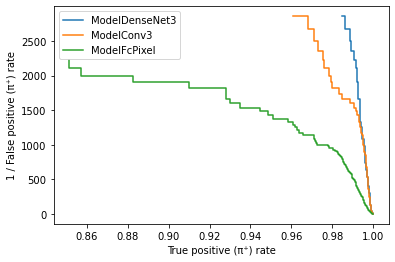

In [356]:
fpr_threshold = 1/3000
tpr_threshold = 0.85

labels = []
handles = []

for name, (y, y_prob) in results.items():
    fpr, tpr, _ = sklearn.metrics.roc_curve(y, y_prob)
    mask = (fpr > fpr_threshold) & (tpr > tpr_threshold)
    handles += plt.plot(tpr[mask], 1/fpr[mask])
    labels.append(name)

plt.xlabel('True positive (π⁺) rate')
plt.ylabel('1 / False positive (π⁺) rate')
plt.legend(handles=handles, labels=labels)
plt.show()

In [357]:
for name, (y, y_prob) in results.items():
    auc = sklearn.metrics.roc_auc_score(y, y_prob)
    print(f'{name:20} ROC AUC = {auc:.7f}; 1/(1-ROC AUC) = {1/(1-auc):.7f}')

ModelDenseNet3       ROC AUC = 0.9998656; 1/(1-ROC AUC) = 7440.5038709
ModelConv3           ROC AUC = 0.9997553; 1/(1-ROC AUC) = 4087.3424202
ModelFcPixel         ROC AUC = 0.9994904; 1/(1-ROC AUC) = 1962.1385741
